In [1]:
import pandas as pd
import numpy as np
import nltk
# Apply text pre-processing to DataFrame
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer

from textblob import TextBlob, Word
import gensim
from gensim import corpora, models, similarities
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
# Fetch stopwords

# import pyLDAvis.gensim
from wordcloud import WordCloud, STOPWORDS

# stop=set(stopwords.words('english')) #for english
stop=set(stopwords.words('indonesian'))


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20612\1263346607.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
# samples= pd.read_csv('dataset/Dataset_clean_textblobvader12112023.csv', encoding='ISO-8859-1')
samples= pd.read_csv('hasil/dataset_resmikpu_clean_content_textblobvader.csv', encoding='UTF-8')
# samples=samples[['likes','replies','quotes','retweets','searchQuery','clean_content']]

In [22]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324 entries, 0 to 2323
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   text                           2324 non-null   object 
 1   clean_content                  2324 non-null   object 
 2   likes                          2324 non-null   int64  
 3   replies                        2324 non-null   int64  
 4   quotes                         2324 non-null   int64  
 5   retweets                       2324 non-null   int64  
 6   searchQuery                    2324 non-null   object 
 7   user_location                  1223 non-null   object 
 8   tanggal                        2324 non-null   object 
 9   date                           2324 non-null   object 
 10  textblob_sentiment             2324 non-null   object 
 11  textblob_sentiment_assessment  2324 non-null   object 
 12  textblob_polarity              2324 non-null   f

In [23]:
def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['clean_content']:
        words=[w for w in word_tokenize(news) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

In [24]:
#buat corpus untuk LDA
corpus=preprocess_news(samples)

In [25]:
len(corpus)

2324

## WORD2VEC

In [26]:
import re

In [27]:
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [28]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['clean_content'] = df.clean_content.str.lower()
    df['document_sentences'] = df.clean_content.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists
    return df

wordsamples=w2v_preprocessing(samples)

In [29]:
wordsamples.head()

,text,clean_content,likes,replies,quotes,retweets,searchQuery,user_location,tanggal,date,...,textblob_sentiment_assessment,textblob_polarity,textblob_subject,vader_compound,vader_neg,vader_neu,vader_pos,vader_sentiment,document_sentences,tokenized_sentences
0,Analisis yang keren banget dari Bang Hasan Nas...,analisis keren banget bang hasan nasbi nih men...,135,32,5,84,#indonesiamaju,"DKI Jakarta, Indonesia",11/21/2023,2023-11-21,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[analisis keren banget bang hasan nasbi nih me...,"[[analisis, keren, banget, bang, hasan, nasbi,..."
1,"Mari kita bersatu, kita fokus melihat ke depan...",mari satu fokus fokus cari putra putri baik ba...,256,69,5,103,#indonesiamaju,Indonesia Raya,11/21/2023,2023-11-21,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[mari satu fokus fokus cari putra putri baik b...,"[[mari, satu, fokus, fokus, cari, putra, putri..."
2,Gubernur BI : Pertumbuhan Ekonomi Indonesia Te...,gubernur bi tumbuh ekonomi indonesia baik indo...,1,0,0,0,#indonesiamaju,"Bangka Belitung, Indonesia",11/22/2023,2023-11-22,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[gubernur bi tumbuh ekonomi indonesia baik ind...,"[[gubernur, bi, tumbuh, ekonomi, indonesia, ba..."
3,Gubernur BI : Pertumbuhan Ekonomi Indonesia Te...,gubernur bi tumbuh ekonomi indonesia baik indo...,1,0,0,0,#indonesiamaju,"Bangka Belitung, Indonesia",11/22/2023,2023-11-22,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[gubernur bi tumbuh ekonomi indonesia baik ind...,"[[gubernur, bi, tumbuh, ekonomi, indonesia, ba..."
4,Stabilitas Pertumbuhan Ekonomi Indonesia \n\n#...,stabilitas tumbuh ekonomi indonesia ekonomi in...,1,0,0,0,#indonesiamaju,"Bangka Belitung, Indonesia",11/22/2023,2023-11-22,...,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",0.0,0.0,0.0,0.0,1.0,0.0,Neutral,[stabilitas tumbuh ekonomi indonesia ekonomi i...,"[[stabilitas, tumbuh, ekonomi, indonesia, ekon..."


In [30]:
wordsamples.to_csv( "hasil/3.KPUResmi_cleancontent_textblobvader_word2vec_processing.csv", index=False, encoding='utf-8-sig')

In [31]:
def lda_get_good_tokens(df):
    df['text_clean'] = df.clean_content.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.clean_content))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))
    return df

wordsamplesx=lda_get_good_tokens(samples)

In [33]:
wordsamplesx.head()

,text,clean_content,likes,replies,quotes,retweets,searchQuery,user_location,tanggal,date,...,textblob_subject,vader_compound,vader_neg,vader_neu,vader_pos,vader_sentiment,document_sentences,tokenized_sentences,text_clean,tokenized_text
0,Analisis yang keren banget dari Bang Hasan Nas...,analisis keren banget bang hasan nasbi nih men...,135,32,5,84,#indonesiamaju,"DKI Jakarta, Indonesia",11/21/2023,2023-11-21,...,0.0,0.0,0.0,1.0,0.0,Neutral,[analisis keren banget bang hasan nasbi nih me...,"[[analisis, keren, banget, bang, hasan, nasbi,...",analisis keren banget bang hasan nasbi nih men...,"[analisis, keren, banget, bang, hasan, nasbi, ..."
1,"Mari kita bersatu, kita fokus melihat ke depan...",mari satu fokus fokus cari putra putri baik ba...,256,69,5,103,#indonesiamaju,Indonesia Raya,11/21/2023,2023-11-21,...,0.0,0.0,0.0,1.0,0.0,Neutral,[mari satu fokus fokus cari putra putri baik b...,"[[mari, satu, fokus, fokus, cari, putra, putri...",mari satu fokus fokus cari putra putri baik ba...,"[mari, satu, fokus, fokus, cari, putra, putri,..."
2,Gubernur BI : Pertumbuhan Ekonomi Indonesia Te...,gubernur bi tumbuh ekonomi indonesia baik indo...,1,0,0,0,#indonesiamaju,"Bangka Belitung, Indonesia",11/22/2023,2023-11-22,...,0.0,0.0,0.0,1.0,0.0,Neutral,[gubernur bi tumbuh ekonomi indonesia baik ind...,"[[gubernur, bi, tumbuh, ekonomi, indonesia, ba...",gubernur bi tumbuh ekonomi indonesia baik indo...,"[gubernur, bi, tumbuh, ekonomi, indonesia, bai..."
3,Gubernur BI : Pertumbuhan Ekonomi Indonesia Te...,gubernur bi tumbuh ekonomi indonesia baik indo...,1,0,0,0,#indonesiamaju,"Bangka Belitung, Indonesia",11/22/2023,2023-11-22,...,0.0,0.0,0.0,1.0,0.0,Neutral,[gubernur bi tumbuh ekonomi indonesia baik ind...,"[[gubernur, bi, tumbuh, ekonomi, indonesia, ba...",gubernur bi tumbuh ekonomi indonesia baik indo...,"[gubernur, bi, tumbuh, ekonomi, indonesia, bai..."
4,Stabilitas Pertumbuhan Ekonomi Indonesia \n\n#...,stabilitas tumbuh ekonomi indonesia ekonomi in...,1,0,0,0,#indonesiamaju,"Bangka Belitung, Indonesia",11/22/2023,2023-11-22,...,0.0,0.0,0.0,1.0,0.0,Neutral,[stabilitas tumbuh ekonomi indonesia ekonomi i...,"[[stabilitas, tumbuh, ekonomi, indonesia, ekon...",stabilitas tumbuh ekonomi indonesia ekonomi in...,"[stabilitas, tumbuh, ekonomi, indonesia, ekono..."


In [34]:
wordsamplesx.to_csv( "hasil/3.KPUResmi_cleancontent_textblobvader_word2vec_ldagoodtoken.csv", index=False, encoding='utf-8-sig')

In [35]:
from collections import Counter
tokenized_only_dict = Counter(np.concatenate(samples.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [37]:
tokenized_only_df.head(10)

,count
analisis,4
keren,30
banget,43
bang,13
hasan,2
nasbi,2
nih,43
menang,166
prabowo,466
gibran,350


In [38]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

In [39]:
print(tokenized_only_df)

               count
ganjar          1670
ganjarpranowo   1239
ganjarmahfud     921
mahfud           851
mahfudmd         779
...              ...
ganjarbokep        1
layang             1
bella              1
irish              1
rencana            1

[4839 rows x 1 columns]


In [40]:
tokenized_only_df.to_csv( "hasil/3.KPUResmi_cleancontent_textblobvader_word2vec_tokenizedcount.csv", index=False, encoding='utf-8-sig')

## TFIDF TOPIC

In [41]:
#buat dictionary corpus
dic=gensim.corpora.Dictionary(corpus)


In [42]:
#buat dictionary corpus
print(dic)

Dictionary<4480 unique tokens: ['analisis', 'bang', 'banget', 'bersamaindonesiamaju', 'dekade']...>


In [43]:
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [44]:
print(bow_corpus)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1)], [(9, 1), (15, 1), (16, 1), (17, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)], [(9, 1), (25, 2), (30, 1), (31, 1), (32, 1)], [(9, 1), (25, 2), (30, 1), (31, 1), (32, 1)], [(9, 1), (25, 1), (30, 2), (32, 1), (33, 1)], [(9, 1), (25, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(5, 2), (11, 1), (15, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 2), (45, 1), (46, 2), (47, 1)], [(3, 1), (4, 1), (5, 1), (11, 1), (12, 1), (14, 1), (15, 2), (16, 1), (18, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 2), (57, 1)], [(9, 1), (25, 1), (30, 2), (32, 1), (33, 1)], [(9, 1), (25, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)], [(1, 1), (4, 1), (5, 2), (7, 1), (8, 1), (12, 1), (13, 1), (15, 2), (16, 1), (18, 1), (58, 1), (59, 1), (60, 

In [45]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

In [46]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)

In [47]:
lda_model = LdaModel(corpus=bow_corpus,
                   id2word=dic,
                   num_topics=4,
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   passes=10,
                #    workers=2,
                   per_word_topics=True)

In [48]:
lda_model.show_topics()

[(0,
  '0.087*"ganjar" + 0.071*"ganjarpranowo" + 0.057*"mahfudmd" + 0.046*"ganjarmahfud" + 0.039*"mahfud" + 0.023*"indonesia" + 0.018*"nomor" + 0.018*"capres" + 0.014*"ganjarpresiden" + 0.013*"sahabatganjar"'),
 (1,
  '0.016*"aminajadulu" + 0.010*"piped" + 0.010*"video" + 0.008*"news" + 0.008*"butuh" + 0.007*"com" + 0.007*"zaslu" + 0.007*"uje" + 0.006*"mantap" + 0.006*"keluarga"'),
 (2,
  '0.072*"amin" + 0.057*"anies" + 0.026*"prabowo" + 0.022*"aniesbaswedan" + 0.019*"pilpres" + 0.018*"cakimin" + 0.018*"gibran" + 0.017*"aniesmuhaimin" + 0.011*"com" + 0.011*"pemilu"'),
 (3,
  '0.018*"indonesia" + 0.017*"amin" + 0.014*"pkb" + 0.013*"epex" + 0.011*"bersamagama" + 0.010*"pangan" + 0.010*"allah" + 0.010*"form" + 0.010*"mari" + 0.010*"kamimuak"')]

In [25]:
# g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

## Visualize the Topic

Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.

Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed. 

Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image below, there are about 22,000 of the word ‘go’, and this term is used about 10,000 times within topic 1. The word with the longest red bar is the word that is used the most by the tweets belonging to that topic.


In [49]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.269550 -0.160336       1        1  47.873179
2     -0.083600  0.269346       2        1  29.991648
3      0.163213 -0.000134       3        1  12.286769
1      0.189937 -0.108876       4        1   9.848403, topic_info=               Term         Freq        Total Category  logprob  loglift
71           ganjar  1460.000000  1460.000000  Default  30.0000  30.0000
277   ganjarpranowo  1191.000000  1191.000000  Default  29.0000  29.0000
1293           amin   833.000000   833.000000  Default  28.0000  28.0000
81            anies   603.000000   603.000000  Default  27.0000  27.0000
664        mahfudmd   952.000000   952.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
3341     musyawarat    12.785835    13.655693   Topic4  -5.5965   2.2520
3342          pslnj    12.785835    13.655693   Topic4  -5.5965   2.2520
3343            rph    12.785835    13.655693   Topic4  -5.5965   2.2520
307           video    33.949938    50.140439   Topic4  -4.6199   1.9279
39              com    25.506615   190.278062   Topic4  -4.9059   0.3083

[192 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1116      1  0.993883     adil
942       3  0.987275     ajak
156       3  0.975154    allah
1293      2  0.910515     amin
1293      3  0.088772     amin
...     ...       ...      ...
282       1  0.886395    viral
282       2  0.109282    viral
1383      3  0.987345    wujud
453       4  0.934444  youtube
4425      4  0.950866    zaslu

[183 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

The further the bubbles are away from each other, the more different they are. For example, it is difficult to tell the difference between topics 1 and 2. They seem to be both about social life, but it is much easier to tell the difference between topics 1 and 3. We can tell that topic 3 is about politics.

## LDA MALLET

## WORDCLOUD GENERATION

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1 
        )
    
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()

c:\laragon\bin\python\python-3.10\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


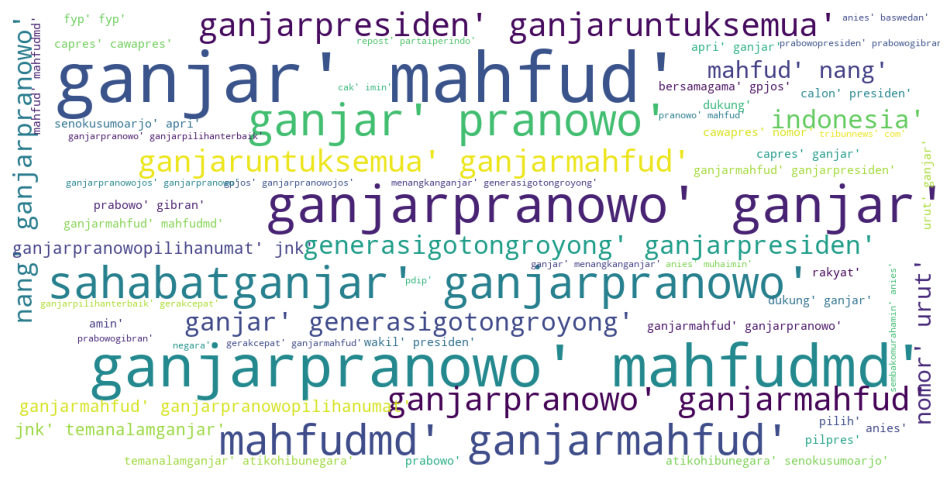

In [52]:
show_wordcloud(corpus)

In [30]:
!pip install nbformat

In [60]:
# import plotly.plotly as py
from chart_studio.grid_objs import Grid, Column
from chart_studio import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.figure_factory as FF

In [61]:
tokenized_only_df.head(25)

,count
ganjar,1670
ganjarpranowo,1239
ganjarmahfud,921
mahfud,851
mahfudmd,779
indonesia,523
prabowo,466
sahabatganjar,351
gibran,350
ganjarpresiden,338


In [62]:
len(tokenized_only_df)

4839

In [ ]:
tokenized_only_df.shape

In [64]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=20):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))
    sns.barplot(x=df.values, y=df.index, alpha=0.8)

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    


In [39]:
# ax = word_frequency_barplot(tokenized_only_df)
# ax.set_title("Word Frequencies", fontsize=16);

In [66]:
samples['date'] = pd.to_datetime(samples['date'], format='mixed')
samplesT = samples['date']

trace = go.Histogram(
    x=samplesT,
    marker=dict(
        color='blue'
    ),
    opacity=0.75
)

layout = go.Layout(
    title='Tweet Activity Over Months',
    height=450,
    width=1200,
    xaxis=dict(
        title='Date and Month'
    ),
    yaxis=dict(
        title='Tweet Quantity'
    ),
    bargap=0.2,
)

data = [trace]

fig = go.Figure(data=data, layout=layout)
pyoff.iplot(fig)

In [110]:
datestat=samples.groupby(['date'],as_index=False).size()
# searchstat.to_frame()

In [111]:
datestat.head(10)

,date,size
0,2023-11-13,33
1,2023-11-14,51
2,2023-11-15,167
3,2023-11-16,131
4,2023-11-17,117
5,2023-11-18,123
6,2023-11-19,107
7,2023-11-20,217
8,2023-11-21,692
9,2023-11-22,686


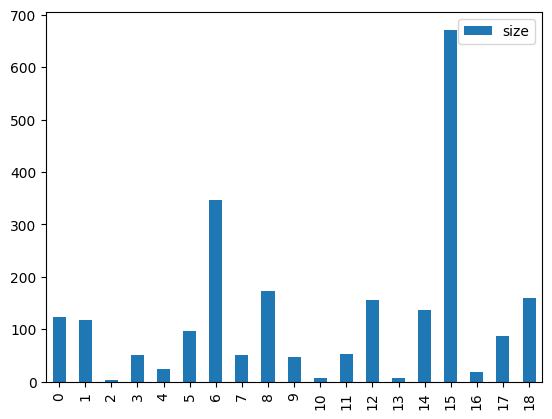

In [118]:
searchstat=samples.groupby(['searchQuery'],as_index=False).size().plot(kind='bar')


In [113]:
searchstat.head(10)

,searchQuery,size
0,#AMIN,123
1,#anies,117
2,#anies2024,2
3,#aniesbaswedan,51
4,#aniesmuhaimin,24
5,#cakimin,97
6,#ganjar,346
7,#ganjar2024,51
8,#ganjarmahfud,173
9,#ganjarpranowo,47


<Axes: xlabel='count', ylabel='searchQuery'>

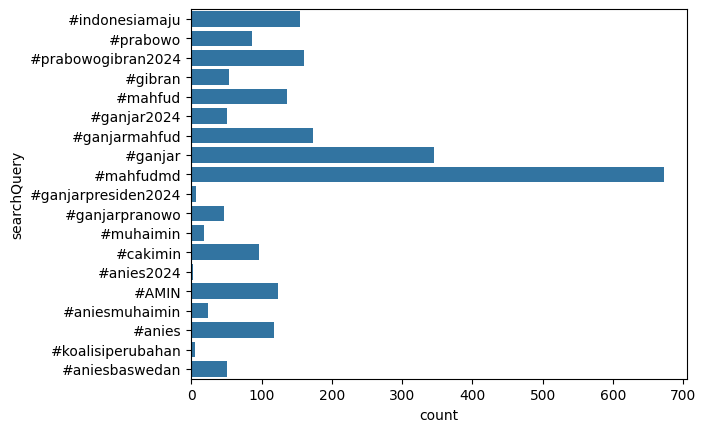

In [127]:
sns.countplot(samples['searchQuery'])

## Vectorize Word

In [40]:
samples.head()

,likes,replies,quotes,retweets,searchQuery,clean_content,tanggal,date,textblob_sentiment,textblob_sentiment_assessment,...,textblob_subject,vader_compound,vader_neg,vader_neu,vader_pos,vader_sentiment,document_sentences,tokenized_sentences,text,tokenized_text
0,0,0,0,0,#gibran,result togel november jogjatoto palembang pool...,11/7/2023,2023-11-07,Neutral,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",...,0.0,0.0,0.0,1.0,0.0,Neutral,[result togel november jogjatoto palembang poo...,"[[result, togel, november, jogjatoto, palemban...",result togel november jogjatoto palembang pool...,"[result, togel, november, jogjatoto, palembang..."
1,0,0,0,0,#gibran,result togel november jogjatoto sunda pools co...,11/7/2023,2023-11-07,Neutral,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",...,0.0,0.0,0.0,1.0,0.0,Neutral,[result togel november jogjatoto sunda pools c...,"[[result, togel, november, jogjatoto, sunda, p...",result togel november jogjatoto sunda pools co...,"[result, togel, november, jogjatoto, sunda, po..."
2,0,0,0,0,#gibran,result togel november jogjatoto belarusia pool...,11/7/2023,2023-11-07,Neutral,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",...,0.0,0.0,0.0,1.0,0.0,Neutral,[result togel november jogjatoto belarusia poo...,"[[result, togel, november, jogjatoto, belarusi...",result togel november jogjatoto belarusia pool...,"[result, togel, november, jogjatoto, belarusia..."
3,0,0,0,0,#gibran,result togel november jogjatoto toto macau sea...,11/7/2023,2023-11-07,Neutral,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",...,0.0,0.0,0.0,1.0,0.0,Neutral,[result togel november jogjatoto toto macau se...,"[[result, togel, november, jogjatoto, toto, ma...",result togel november jogjatoto toto macau sea...,"[result, togel, november, jogjatoto, toto, mac..."
4,0,0,0,0,#cakimin,politik muhaiminiskandar cakimin mahasiswaunis...,11/7/2023,2023-11-07,Neutral,"Sentiment(polarity=0.0, subjectivity=0.0, asse...",...,0.0,0.0,0.0,1.0,0.0,Neutral,[politik muhaiminiskandar cakimin mahasiswauni...,"[[politik, muhaiminiskandar, cakimin, mahasisw...",politik muhaiminiskandar cakimin mahasiswaunis...,"[politik, muhaiminiskandar, cakimin, mahasiswa..."


In [ ]:
from gensim.corpora import Dictionary

In [ ]:

dictionary = Dictionary(documents=samples.tokenized_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 8069 words.


In [ ]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.tokenized_text))
    
document_to_bow(samples)

In [ ]:


# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)



In [ ]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [ ]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)

In [ ]:
cleansed_words_df.head()

,count
ganjar,2361
mahfud,1813
anies,1763
prabowo,1548
gibran,1283


In [ ]:


# ax = word_frequency_barplot(cleansed_words_df)
# ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);



In [69]:
# df = pd.DataFrame({'date': s.index, 'Category': s.values})
# samples['Week/Year'] = samples['date'].apply(lambda x: "%d/%d" % (x.week, x.year))
# samples.groupby(['Week/Year', 'Category']).size()
samples.groupby(['date']).size()

date
2023-11-13     33
2023-11-14     51
2023-11-15    167
2023-11-16    131
2023-11-17    117
2023-11-18    123
2023-11-19    107
2023-11-20    217
2023-11-21    692
2023-11-22    686
dtype: int64